# The increasing threat of wildfires in the U.S.A.
by Joey Rucska

February 2023

One of the most visible and dramatic outcomes of climate change in the United States is the growing frequency of massive wildfires. The west coast region and Alaska are particularly susceptible. In recent years there have been several dramatic events where smoke turned entire skies orange and opaque, like in the image below. The dangers of wildfires are obvious. They threaten infrastructure, ecosystems, and human lives. Understanding how wildfires activity is changing is a crucial part of mitigating their future impacts.

On this webpage I present an analysis of a publicly available [dataset](https://www.kaggle.com/datasets/behroozsohrabi/us-wildfire-records-6th-edition) cataloguing 2.3 million wildfires within the U.S.A. between 1992 and 2020. I show that the occurence of fires is cyclical--oscillating between relatively heavy and low fire abundances with a cycle length or period of 2-3 years. Underlying the oscillations is an increasing trend in the typical fire size and the total annual surface area affected by fires. Approximately 190,000 additional acres per year are affected by fires, on average, adding to annual totals that already amount to a few-several millions of acres. Large fires are becoming more frequent quicker than smaller fires. During years of peak activity between 2015-2020, there was nearly double the total acreage affected by large fires when compared to the average over the 1992-2020 period. Lastly, a spatial map of wildfire activity demonstrates that the western coast of the conintental U.S. and Alaska are more suspectible to wildfires than other regions.

The Jupyter Notebook for this project is available on [Github](https://github.com/rucskajj/Data-Science-Projects/tree/main/USWildfires00-20).

<img src="https://live.staticflickr.com/65535/50324593222_7432c54dce_b.jpg" alt="The Day The Sun Didn't Rise | Christopher Michel" width="700" />

"The Day The Sun Didn't Rise" by Christopher Michel, via [Flickr](https://flic.kr/p/2jEZMCE), reproduced without alterations under Creative Commons License ([CC BY-NC-ND 2.0](https://creativecommons.org/licenses/by-nc-nd/2.0/)). All right belongs to the artist.

## Overview of the dataset

Each entry in the data set includes the date the fire was discovered, the size of the fire damage in acres, the [letter class](https://www.nwcg.gov/term/glossary/size-class-of-fire) of the size of the fire (A-G), the cause of the fire, and the approximate latitude and longitude of the fire, among several other things. 

Looking at the distribution of all fire sizes from 1992-2020, plotted below, we see there are many entries for fires < 10 acres. The distribution at this small size end features narrow peaks that are most definitely as result of manual rounding to convenient, integer fractions (e.g. 1 acre, 1/2, 1/4, 2, 3, etc.). Thus, **for the rest of this analysis, I am only going to look at the fires above 100 acres (or class D)**, to focus on the fires that are capable of doing the most damage, or potentially growing into catastrophic fires if they are not controlled in time.

In the below figure, the region bounded by the dotted lines in the left panel (fires > 100 acres) is enlarged in the right panel. The fire class letter boundaries are also shown the right panel.

Note, the data on both axes are presented in logarithmic spacing. The high-end fire size distribution is exponential: there are 100 times more 100-acre fires than 100,000-acre fires.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import plotting_routines as pltrs
from IPython.display import display
import statsmodels.api as sm
plt.rcParams["font.family"] = "serif"

In [2]:
df_dir = "./pandas-dfs/"
df_filename = "fireyear-to-lat-long.pkl"
df = pd.read_pickle(df_dir+df_filename)
#print(df.head()) # Ordered by Discovery Date

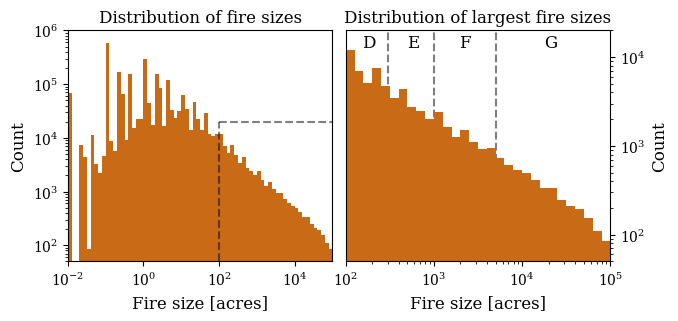

In [3]:
# Create new pandas df for fire above 100 acres
df_lrg = df.loc[(df['FIRE_SIZE'] >= 100), ['NWCG_GENERAL_CAUSE','FIRE_YEAR','FIRE_SIZE',
                                           'DISCOVERY_DOY', 'DISCOVERY_TIME',
                                           'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE']]


# Plot Distributions of Fire Size

fig, axs = plt.subplots(1,2, figsize=[7,3])
plt.subplots_adjust(wspace=0.05)

ax = axs[0]

ax.hist(df['FIRE_SIZE'], bins=np.logspace(-2,5, 71),
       color="#c96a16", zorder=0)
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim([10**(-2),10**(5)])
ax.set_ylim([50,1000000])

# Trace out subset shown in right panel
ax.vlines([100], 50, 20000, colors='k', ls='--', alpha=0.5, zorder=1)
ax.hlines([20000], 10**(2),10**(5), colors='k', ls='--', alpha=0.5, zorder=1)

xticks = ax.xaxis.get_major_ticks()
xticks[-2].label1.set_visible(False)

ax.set_xlabel("Fire size [acres]", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Distribution of fire sizes")

ax = axs[1]

ax.hist(df_lrg['FIRE_SIZE'], bins=np.logspace(2,5, 31), zorder=1, color="#c96a16")

# For labelling the Fire Classes
ax.vlines([300,1000,5000], 50, 20000, colors='k', ls='--', alpha=0.5, zorder=0)
ax.text(0.06, 0.93, "D", fontsize=12, transform=ax.transAxes)
ax.text(0.23, 0.93, "E", fontsize=12, transform=ax.transAxes)
ax.text(0.43, 0.93, "F", fontsize=12, transform=ax.transAxes)
ax.text(0.75, 0.93, "G", fontsize=12, transform=ax.transAxes)

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim([10**(2),10**(5)])
ax.set_ylim([50, 20000])

ax.set_xlabel("Fire size [acres]", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Distribution of largest fire sizes")

plt.show()

One might assume wildfires are more likely to start during the hotter part of the day, and the below plot demonstrates this is true, regardless of whether you look at all fires or just the largest fires. Both distributions (still representing the full 1992-2020 period) peak strongly near 3 in the afternoon.

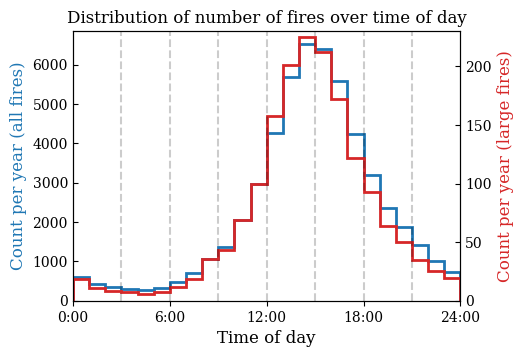

In [4]:
# Drop/clean any entries with no recorded Time of Day
disctime = df['DISCOVERY_TIME'].replace('', np.nan).dropna().astype('int64')
disctime_lf = df_lrg['DISCOVERY_TIME'].replace('', np.nan).dropna().astype('int64')

fig, ax = plt.subplots(figsize=[5,3.5])

norm = 28 # 28 years in sample, normalization to get bin values in number of fires per year
hist, bin_edges = np.histogram(disctime, bins=np.linspace(0,2400,25))
ax.stairs(hist/norm, bin_edges, lw=2, color='C0')
ax.set_ylabel("Count per year (all fires)", fontsize=12, color='C0')

ax2=ax.twinx()
hist, bin_edges = np.histogram(disctime_lf, bins=np.linspace(0,2400,25))
ax2.stairs(hist/norm, bin_edges, lw=2, color='C3')
ax2.set_ylabel("Count per year (large fires)", fontsize=12, color='C3')

for be in bin_edges[3:-1:3]:
    ax2.vlines(be, 0, 230, color='k', ls='--', alpha=0.2, zorder=1)
ax2.set_ylim([0,230])

ax.tick_params('y', direction='in')
ax2.tick_params('y', direction='in')

ax.set_xlim(0,2400)
ax.set_xticks([0,600,1200,1800,2400])
ax.set_xticklabels(["0:00","6:00","12:00","18:00","24:00"])
ax.set_xlabel('Time of day', fontsize=12)
ax.set_title('Distribution of number of fires over time of day')

plt.show()

There is also a distinct annual fire season--or perhaps two: in early spring from mid-February to the end of May, and then the beginning of June to the end of August. 

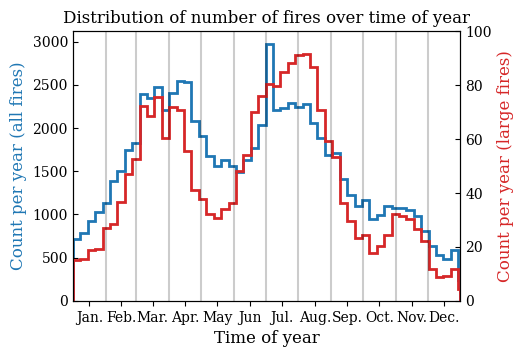

In [5]:
# Drop/clean any entries with no recorded Time of Day
discday = df['DISCOVERY_DOY'].replace('', np.nan).dropna().astype('int64')
discday_lf = df_lrg['DISCOVERY_DOY'].replace('', np.nan).dropna().astype('int64')

# Mark locations of the months in the days of the year, for vertical lines in the plot
days_in_months = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] # Day in each month, using Feb = 29 days
month_bins = np.concatenate([[0],np.cumsum(days_in_months)]) # Make array of bin edges using cumsum
month_ticks = (0.5*(month_bins[1::]-month_bins[0:-1:])+month_bins[0:-1:]) # x-axis tick locations

# Annual fire date actually binned by week, not by month, for the histogram
week_bins = np.arange(0,372,7)
week_bins[-1] = 366

fig, ax = plt.subplots(figsize=[5,3.5])

norm = 28 # to get bin values in number of fires per year
hist, bin_edges = np.histogram(discday, bins=week_bins)
ax.stairs(hist/norm, bin_edges, lw=2, color='C0')
ax.set_ylabel("Count per year (all fires)", fontsize=12, color='C0')

ax2=ax.twinx()
hist, bin_edges = np.histogram(discday_lf, bins=week_bins)
ax2.stairs(hist/norm, bin_edges, lw=2, color='C3')
ax2.set_ylabel("Count per year (large fires)", fontsize=12, color='C3')

# Vertical lines to visualize the months
for mb in month_bins[1:-1]:
    ax2.vlines(mb, 0, 100, color='k', ls='-', alpha=0.2, zorder=1)
ax2.set_ylim([0,100])

ax.tick_params('y', direction='in')
ax2.tick_params('y', direction='in')

ax.set_xlim(0,366)
ax.set_xticks(month_ticks)
ax.set_xticklabels(["Jan.","Feb.","Mar.","Apr.","May","Jun","Jul.","Aug.","Sep.","Oct.","Nov.","Dec."])
ax.set_xlabel('Time of year', fontsize=12)
ax.set_title('Distribution of number of fires over time of year')

plt.show()

According to this dataset, natural causes (lightning strikes, probably) are the main cause of wildfires. Unfortunately, the 2nd largest contributor is in the unknown "missing data" category, and alarmingly, arson is the 3rd most prominent cause, with 10,886 deliberate fires set between 1992-2020, or approximately 1 fire (above 100 acres!) per day, on average.

In [16]:
# Make table counting causes of the fire -- "NWCG_GENERAL_CAUSE" in the original dataset
dfcausecounts = df_lrg['NWCG_GENERAL_CAUSE'].value_counts().to_frame()

# Book keeping for the table column header
dfcausecounts.rename(columns={'NWCG_GENERAL_CAUSE': 'Counts'}, inplace=True)
dfcausecounts['Cause of fire'] = dfcausecounts.index
dfcausecounts = dfcausecounts[['Cause of fire','Counts']]

# Use pandas dataframe styler to make the table
styler = dfcausecounts.style
styler.set_caption("Cause of the largest U.S. wildfires from 1992-2020")
styler.hide(axis="index")
display(styler)

Cause of fire,Counts
Natural,19579
Missing data/not specified/undetermined,15774
Arson/incendiarism,10886
Debris and open burning,8125
Equipment and vehicle use,5700
Power generation/transmission/distribution,1428
Recreation and ceremony,1296
Railroad operations and maintenance,980
Smoking,660
Fireworks,445


## The growing strength of large wildfires

The following figure shows the median, mean, and sum of fire sizes, and the total number of fires, over time, from 1992-2020. In these data, the cyclical, osciallatory behavior of wildfire activity is apparent. Fire presence oscillates between maxima and minimuma over the course of 2-3 year periods. Previous plots demonstrated strong daily and annual cycles in activity, which suggests these super-annual cycles are a result of some larger climate pattern that is decoupled from either annual or daily temperature fluctuations. Alarmingly, all lines with the exception of the total number of fires appear to be gradually increasing. Both the upper and lower bounds of the peaks of the oscillation increase with time. For example, from 1992-1996, the total area affected by wildfire oscillated between ~2 and 4 million acres per year, while the totals from 2016-2020 were between 4 and 10 million.

That the number of fires (yellow) does not follow this trend suggests that larger fires are increasing in relative number. I investigate this possibility in a future figure.

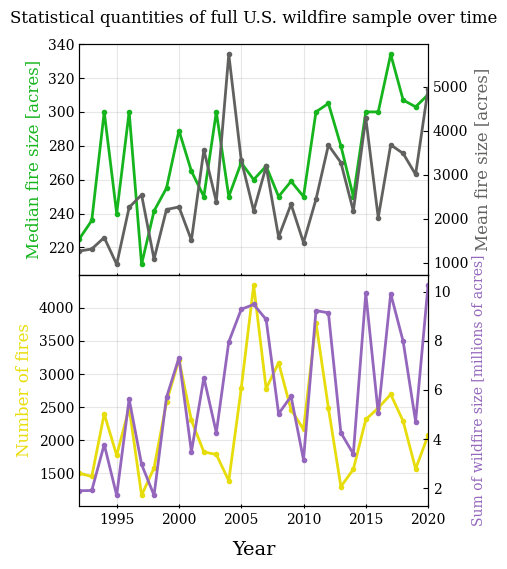

In [7]:
def compute_firesize_overtime(dataframe):
    """ Return arrays/pandas series of median, mean, sum of fire size,
        and count of number of fires."""
    median = dataframe.groupby(['FIRE_YEAR'])['FIRE_SIZE'].median()
    mean = dataframe.groupby(['FIRE_YEAR'])['FIRE_SIZE'].mean()
    summ = dataframe.groupby(['FIRE_YEAR'])['FIRE_SIZE'].sum()
    count = dataframe.groupby(['FIRE_YEAR'])['FIRE_SIZE'].count()
    return median, mean, summ, count
    
med_all, mean_all, sum_all, cnt_all = compute_firesize_overtime(df_lrg)
# Calling my own plotting routine from accompanying plotting_routines.py
pltrs.plot_firesize_overtime(med_all, mean_all, sum_all, cnt_all,
                       "Statistical quantities of full U.S. wildfire sample over time")

I explore the increasing trend of fire activity more quantitatively using a linear regression analysis on the total or sum of annual surface area affected by fires. I employ a simple ordinary least squares method using the `statsmodels` package. Plots of the data, the linear fit, and the residuals are below.

The model predicts a slope value of $m=0.187\pm0.053$, where the uncertainty here is the standard error from the regression. Given the units of the y-axis, This translates to conclusion that the underlying baseline value around which wildfire activity oscillates is increasing by approximately ~190,000 affected acres per year.

The $R^2$ value of the fit is 0.314, a rather small value, which is not surprising given the lack of data points clustered near the trendline. As stated before, the natural behavior of the system appears to support osciallations between periods of relatively high and low activity, with a repetition period of ~2-3 years. The residuals display a biomodal distribution with peaks near $\pm(0.5-1)$ standard deviation. It would be beneficial to extend this dataset to include the extra two years to the current date, or find archival data from before 1992, if possible. I am curious (and worried) to know whether this increase of 190,000 acres of fires per year is compatible with recent data.

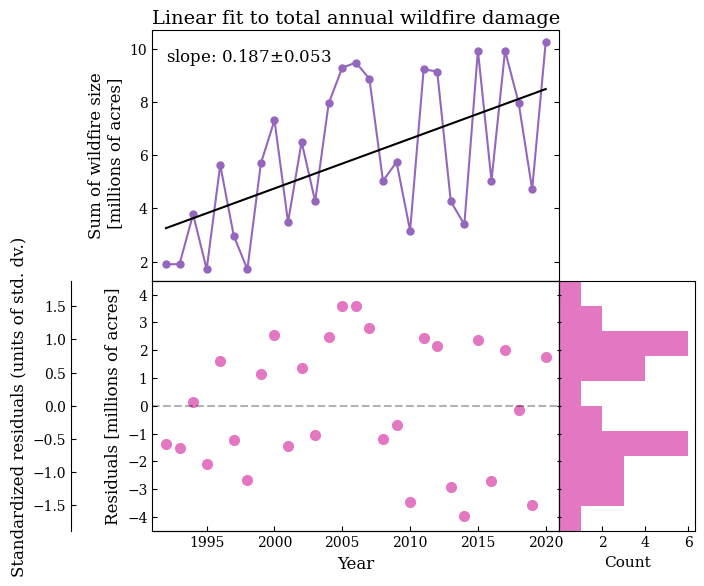

In [8]:
years_sm = sum_all.index
fire_sum = sum_all.values/1e6
yr = years_sm.copy()
# add constant term for statsmodels fit
years_sm = sm.add_constant(years_sm)

# fit model with Ordinary Least Squares technique
result = sm.OLS(fire_sum, years_sm).fit()
fitparams = result.params
#print(result.summary())

fig, axes = plt.subplots(2,2, gridspec_kw={'width_ratios': [3, 1]}, figsize=[7,6.5])
plt.subplots_adjust(wspace=0.0, hspace=0.0)
axes[0,1].axis("off")

# On this axis: Data with linear trend
ax = axes[0,0]
ax.plot(sum_all/1e6, '.-', ms=10, color='C4')
ax.plot(yr, result.fittedvalues, color='k')
ax.set_xlim([yr.min()-1, yr.max()+1])
ax.set_ylabel("Sum of wildfire size\n [millions of acres]", fontsize=12)
ax.set_title("Linear fit to total annual wildfire damage", fontsize=14, pad=5)
ax.tick_params('y', direction='in')
ax.yaxis.set_ticks_position('both')
ax.text(1992, 9.5,
        "slope: {:.3f}$\pm${:.3f}".format(result.params[1], result.bse[1]),
       fontsize=12)

# On this axis: Residuals, in two units
ax = axes[1,0]
residlim = 4.5
ax.plot(yr, result.resid,
        '.', ms=14, color='C6')
ax.set_xlim([yr.min()-1, yr.max()+1])
# Units of fire sum (millions of acres)
ax.set_ylim([-residlim, residlim])
ax.hlines(0.0, yr.min()-1, yr.max()+1, ls='--', color='k', alpha=0.3)
ax.set_ylabel("Residuals [millions of acres]", fontsize=12)
ax.set_xlabel("Year", fontsize=12)
ax.tick_params('both', direction='in')

ax2 = ax.twinx()
# Units of standardized residuals
ax2.set_ylim([-residlim/np.sqrt(result.mse_resid),
              residlim/np.sqrt(result.mse_resid)])
ax2.spines["left"].set_position(("axes", -0.2))
ax2.spines["left"].set_visible(True)
ax2.yaxis.set_label_position('left')
ax2.yaxis.set_ticks_position('left')
ax2.set_ylabel("Standardized residuals (units of std. dv.)", fontsize=12)
ax2.tick_params('y', direction='in')

# On this axis: histogram of residuals
ax = axes[1,1]

bins = np.linspace(-residlim, residlim, 11)
ax.hist(result.resid, bins=bins, color='C6',
        orientation="horizontal")
ax.set_xticks([2,4,6])
ax.set_yticklabels("")
ax.set_ylim([-residlim, residlim])
ax.set_xlabel("Count", fontsize=11)
ax.tick_params('y', direction='inout')
ax.tick_params('x', direction='in')

plt.show()

In the below figure, the total sum of surface area affected by wildfires over time is split by the [class](https://www.nwcg.gov/term/glossary/size-class-of-fire) representing the fire size. The sum is represented as a ratio to the mean annual total fire size area over the full 1992-2020 period. Values of 1 on the vertical axis thus represent years where the total burn was close the average year, and values of 1.5 represent years where there was 50% more fire area than the average. 

When split by fire size class, we can see the largest > 5,000 acre G fires are experiencing a sharper increasing trend over time. Early in the trend, near 1995, the G class fires are oscillating between 25-75% of the mean, while near 2015 they oscillate between 75-175% of the mean. The trend in the D, E, and F class fires is less pronounced.

It is the G class fires that do the most damage in the worst cases cause evacuations of towns and cities. That they are becoming more likely is an unsettling trend.

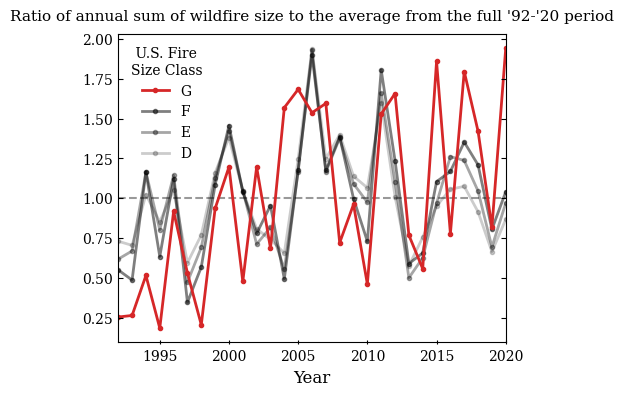

In [9]:
fig, ax = plt.subplots(figsize=[5,4])

size_classes = sorted(df_lrg['FIRE_SIZE_CLASS'].unique()) # sorted alphabetically

# Plot properties for the different classes
alphas = [1.0,0.5,0.35,0.2]
colours = ['C3', 'k', 'k', 'k']
zorders = [1, 0, 0, 0]
ai = 0

for sc in np.flip(size_classes): # flip Size Class list to do largest fires first
    df1 = df_lrg.loc[(df_lrg['FIRE_SIZE_CLASS'] == sc),['FIRE_YEAR', 'FIRE_SIZE']]
    # Use pandas grouby() to sum fire size in each year
    sumfsize = df1.groupby(['FIRE_YEAR'])['FIRE_SIZE'].sum()
    plt.plot(sumfsize/np.mean(sumfsize), '.-', lw=2,
             color=colours[ai], alpha=alphas[ai], zorder=zorders[ai],
            label=sc)
    ai += 1

# Add a horizontal line at 1.0. This line represents the mean
ax.hlines(1.0, sumfsize.index.min(), sumfsize.index.max(),
              color="k", ls="--", alpha=0.4, zorder=0)
    
ax.set_xlabel("Year",fontsize=12)
ax.set_title("Ratio of annual sum of wildfire size to the average from the full '92-'20 period", fontsize=11, pad=10)
ax.legend(title=" U.S. Fire\nSize Class",frameon=False)
ax.set_xlim([sumfsize.index.min(), sumfsize.index.max()])
ax.tick_params('y', direction='in')
ax.tick_params('x', direction='inout')
ax.yaxis.set_ticks_position('both')
plt.show()

## A look at the largest fires from 2000-2019

In the following figures, I will focus on the fires between \[2000-2009\] and \[2010-2019\], to make a comparison between two decades.

The below table presents the largest fires on record across these two decades, and the following map shows where they occured. The numbers beside each dot denote the rank/order of the fire in the top 10 list, with red colours representing the \[2010-2019\] decade and blue colours representing \[2000-2009\].

In [10]:
# Grab the subset of fires from [2000-2019], then take only the 10 largest
lrgfires_00_20 = df_lrg[(df_lrg['FIRE_YEAR'] >= 2000) & (df_lrg['FIRE_YEAR'] < 2020)]
lrgfires_00_20 = lrgfires_00_20.sort_values(by='FIRE_SIZE', ascending=False).head(n=10)

# For formatting the data and labels in the table
lrgfires_00_20.rename(columns={'FIRE_YEAR': 'Year', 'FIRE_SIZE': 'Size',
                              'LATITUDE': 'Latitude', 'LONGITUDE': 'Longitude'},inplace=True)
lrgfires_00_20['Size'] = lrgfires_00_20['Size'].div(1000).map('{:.1f}'.format)
lrgfires_00_20['Latitude'] = lrgfires_00_20['Latitude'].map('{:.3f}'.format)
lrgfires_00_20['Longitude'] = lrgfires_00_20['Longitude'].map('{:.3f}'.format)
lrgfires_00_20.rename(columns={'Size': 'Size (thousands of acres)'}, inplace=True)

# Use pandas dataframe styler to print table
styler = lrgfires_00_20[['Year','Size (thousands of acres)', 'Latitude', 'Longitude']].style
styler.hide(axis="index")
styler.set_caption("Top 10 largest fires in the U.S.A from 2000 to 2019")
styler = display(styler.set_properties(**{
    'text-align': 'center',
    'white-space': 'pre-wrap',
}))

Year,Size (thousands of acres),Latitude,Longitude
2017,662.7,36.774,-100.175
2012,558.2,42.392,-117.894
2011,538.0,33.606,-109.450
2004,537.6,65.266,-146.886
2009,517.1,64.747,-149.505
2002,499.9,42.039,-123.912
2004,483.3,66.303,-149.884
2006,479.5,35.668,-101.371
2004,464.0,63.816,-143.819
2012,461.0,41.973,-118.365


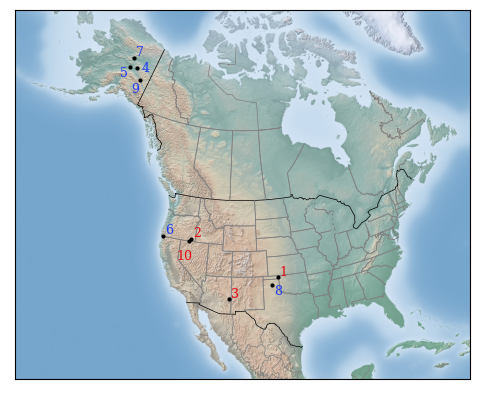

In [11]:
fig, ax = plt.subplots()

# Make the coloured map using Basemap
m = Basemap(width=8000000,height=6500000,projection='lcc',
            resolution='l',lat_0=50,lon_0=-107.)
m.shadedrelief()
m.drawcountries()
m.drawstates(color='0.5')

# Use the basemap object to convert long & lat to x & y co-ords it can use
x, y = m(lrgfires_00_20['Longitude'], lrgfires_00_20['Latitude'])
ax.plot(x, y, 'ok', ms=2)

cnti = 0
for i in lrgfires_00_20.index:
    adjx = 0.0; adjy = 0.0;
    
    # Manual adjustments for each number label on the map so that the text
    # does not overlap. Values found via trial and error.
    # Number in the comment represents the number label i.e. the Fire size rank
    if(i == 1412216):   # 4
        adjx = 30000; adjy = -100000;
    elif(i == 1474620): # 5
        adjx = -200000; adjy = -200000;        
    elif(i == 643004):  # 8
        adjx = 0; adjy = -200000;
    elif(i == 1445525): # 9
        adjx = -200000; adjy = -250000;       
    elif(i == 2101843): # 10
        adjx = -250000; adjy = -350000;
        
    # Turn fires from [2000-2009] blue, and [2010-2019] red
    if(lrgfires_00_20.loc[i]['Year'] < 2010):
        textclr = '#1e3bfa'
    else:
        textclr = '#e6020e'
               
    # Add number labels
    plt.text(x[cnti]+35000+adjx, y[cnti]+35000+adjy,
             str(cnti+1), color=textclr, fontsize=9)
    cnti += 1
plt.show()

## Comparing wildfire occurences in Alaska and the Continential U.S.A.

Alaska is unique in this dataset since it is physically separated from the rest of the contiguous United States. Thus, I wished to look at AK and the Con. U.S. individually, to observe the effects of this geographic separation.

In [12]:
# Create new dataframe based on latitude and longitude cuts, separating fires in
# the continental U.S. from Alaska

# Continental U.S.
conUS = df[(df['LATITUDE'] > 23) & (df['LATITUDE'] < 50) &
            (df['LONGITUDE'] > -130)]

# Alaska
AK = df[df['LATITUDE'] > 50]


# Split both subsets into two decades: [2000-2009] and [2010-2019]
# Only grab the data/columns needed for future plots

conUS_00_10 = conUS[(conUS['FIRE_YEAR'] >= 2000) & (conUS['FIRE_YEAR'] < 2010)]
conUS_10_20 = conUS[(conUS['FIRE_YEAR'] >= 2010) & (conUS['FIRE_YEAR'] < 2020)]
conUS_00_20 = conUS[(conUS['FIRE_YEAR'] >= 2000) & (conUS['FIRE_YEAR'] < 2020)]

conUS = conUS.loc[(conUS['FIRE_SIZE'] >= 100), ['NWCG_GENERAL_CAUSE','FIRE_YEAR','FIRE_SIZE',
                                           'DISCOVERY_TIME','FIRE_SIZE_CLASS',
                                           'LONGITUDE','LATITUDE']]

AK_00_10 = AK[(AK['FIRE_YEAR'] >= 2000) & (AK['FIRE_YEAR'] < 2010)]
AK_10_20 = AK[(AK['FIRE_YEAR'] >= 2010) & (AK['FIRE_YEAR'] < 2020)]
AK_00_20 = AK[(AK['FIRE_YEAR'] >= 2000) & (AK['FIRE_YEAR'] < 2020)]

AK = AK.loc[(AK['FIRE_SIZE'] >= 100), ['NWCG_GENERAL_CAUSE','FIRE_YEAR','FIRE_SIZE',
                                           'DISCOVERY_TIME','FIRE_SIZE_CLASS',
                                           'LONGITUDE','LATITUDE']]

Looking at the same statistical properties as before, but split geographically this time, we see the data for the continental U.S. follow similar trends to the country-wide data, where the mean, median and sum follow gentle upwards trends, while the total number of fires does not.

In Alaska, the story is different. There is no obvious trend in any direction for the data. There are notable peaks above a relatively flat baseline, denoting years of heavy fire presence: 2004, 2005, 2009, 2015. Referencing the table and map from the previous section, the 4th, 7th, and 9th largest fires from the last two decades all occured in 2004 in Alaska.

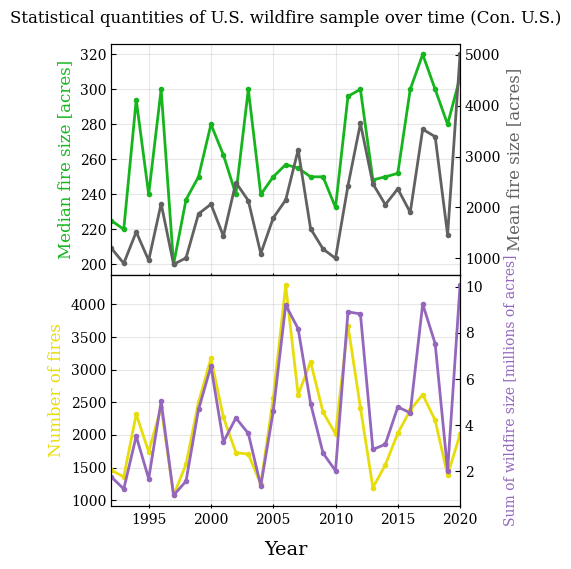

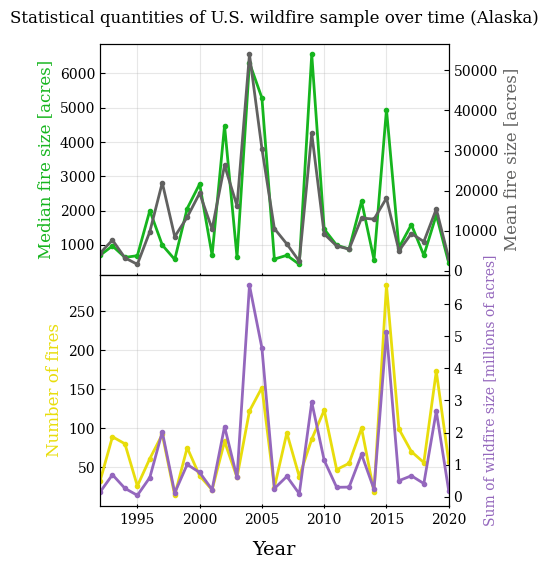

In [13]:
# Using previously defined functions from before to produce similar plots for
# each of the continental U.S. and Alaska subsets

med_cUS, mean_cUS, sum_cUS, cnt_cUS = compute_firesize_overtime(conUS)
med_AK,  mean_AK,  sum_AK,  cnt_AK  = compute_firesize_overtime(AK)

pltrs.plot_firesize_overtime(med_cUS, mean_cUS, sum_cUS, cnt_cUS,
                      "Statistical quantities of U.S. wildfire sample over time (Con. U.S.)")
pltrs.plot_firesize_overtime(med_AK,  mean_AK,  sum_AK,  cnt_AK,
                      "Statistical quantities of U.S. wildfire sample over time (Alaska)")

Below I split the sum of fire damage over time by class, as before, and compare each region (right panels) to the country-wide data (left panels). As above, the con. U.S. follows a similar trend to the national data, where the G-Class fires exhibit the most dramatic growing trend.

Again, the Alaska data has no strong trend, but the peaks from the above figures are especially clear, now that the data have been normalized to the mean from the time period. The worst years had over 5 times (2004) and nearly 4 times (2015) as much total surface area of wildfires as the average.


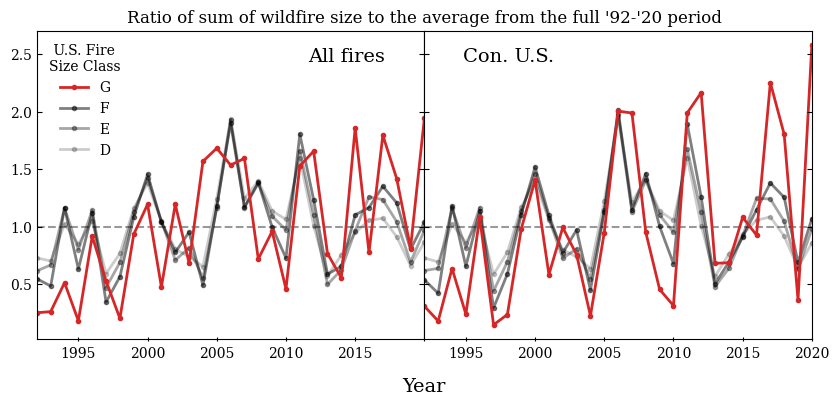

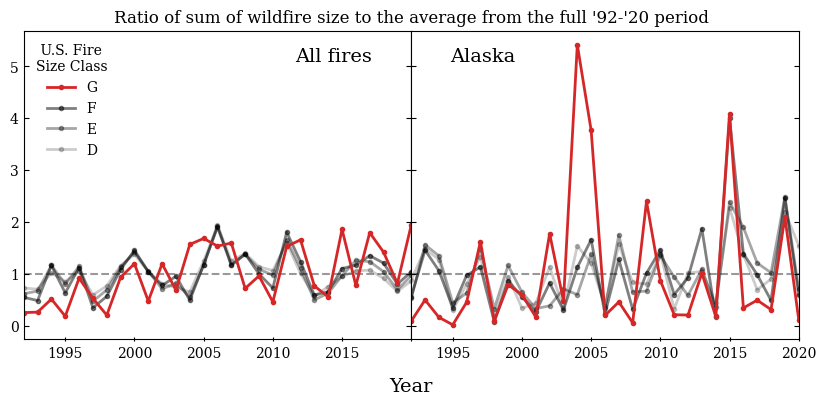

In [14]:
# Another similar plots to before, but now for each of the continental U.S. and Alaska subsets

# Calling my own plotting routine from the accompanying plotting_routines.py
pltrs.plot_firesizeclass_2frame(conUS, df_lrg, "Con. U.S.", size_classes)
pltrs.plot_firesizeclass_2frame(AK, df_lrg, "Alaska", size_classes)

Finally, I look at the spatial distribution of wildfire damage across the con. U.S. and Alaska. Here, each fire (above 100 acres) has been accumulated in (roughly) hexagon-shaped bins, and the colour of the bin represents how much total wildfire (in terms of acres affected) was present in the location represented by the hexagon bin. The first row is for data from \[2000-2009\], the second row from \[2010-2019\], and the third row presents the difference between the two, as a percent of the sum of the total wildfire area from \[2000-2009\].

On these plots, it is obvious the most-affected area of the continental U.S. are the west coast, western interior, north Texas, and Florida. In Alaska, it is primarily the northern interior that is affected by fire. The previously mentioned intense fires between \[2000-2009\] in Alaska are present in the strong red colours in the upper right panel, and the strong blue colours in the lower right. The latter demonstrates that the \[2000-2009\] fires in the region were more intense than the fires that occured from \[2010-2019\].

The percent difference plot for the continentual U.S. shows that most regions in the west experienced an increase in wildfire activity from \[2010-2019\] compared to \[2000-2009\]. There are a few regions coloured blue, but most of the map is shaded red. Overall, the midwest and east coast regions are much less affected by wildfires, and are also not experiencing a noticeable shift in fire activity.

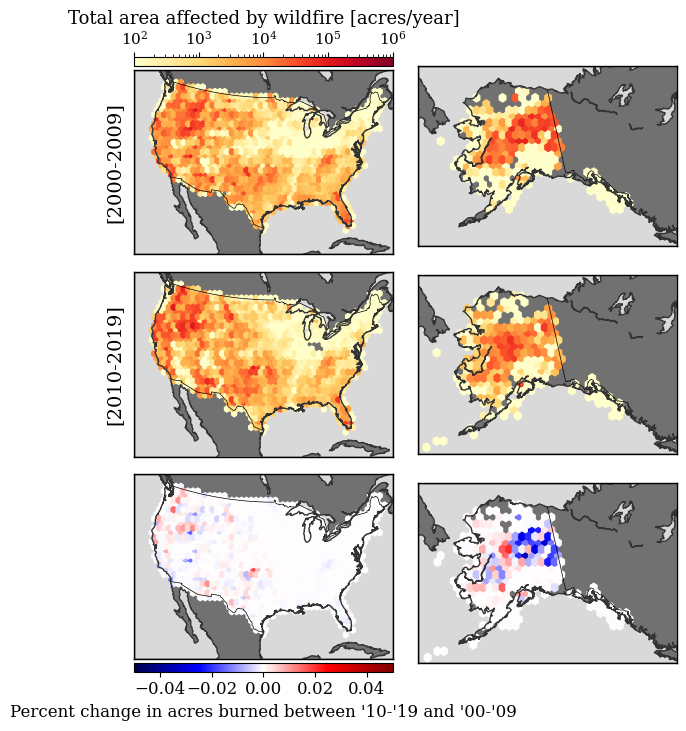

In [15]:
# Defining the boundaries of the map
# lat & long pairs for the lower left and upper right corners, respectively
cUS_corners = [-120, 18, -62, 50];
AK_corners = [-170, 52, -105, 65]

# centering lat. and long.
cUS_ll0 = [40, -95]
AK_ll0 = [62.5, -155]

# gridsize argument to hexbin for each data set
# Manually adjusted until land per hex is roughly equal in each
# map, see prints at the bottom of the cell
cUS_hexgrid = [48,16]; AK_hexgrid = [40,12]; AK_hexgrid2 = [29,12];

# colourbar limits
cblimits = [100,1000000]
cblimits_diff = [-0.05, 0.05]

fig, axs = plt.subplots(3,2, figsize=[7,8])
plt.subplots_adjust(wspace = 0.1, hspace=0.05)

bColourbar = True
plt.axes(axs[0,0])
norm = 10 # normalization by 10 years to get data as # of burned acres per annum.

# All panels here make use of this routine from the accompanying plotting_routines.py
hex_cUS_00_10 = pltrs.plot_hexbin_frame( conUS_00_10, norm,
    cUS_corners, cUS_ll0, cUS_hexgrid,
    bColourbar, cblimits)
plt.ylabel('[2000-2009]', fontsize=14)

bColourbar = False
plt.axes(axs[0,1])
hex_AK_00_10 = pltrs.plot_hexbin_frame( AK_00_10, norm,
    AK_corners, AK_ll0, AK_hexgrid,
    bColourbar, cblimits)

"""
# Check that the sum of hexbin 2D histogram values equals
# the sum of the FIRE_SIZE from the raw data
# From this print I caught that the default function hexbin()
# uses to ammalgamate colour values is mean(), not sum()!
print("sum check:", AK_00_10['FIRE_SIZE'].sum()/norm,
      np.sum(hex_AK_00_10.get_array()))
"""

plt.axes(axs[1,0])
hex_cUS_10_20 = pltrs.plot_hexbin_frame( conUS_10_20, norm,
    cUS_corners, cUS_ll0, cUS_hexgrid,
    bColourbar, cblimits)
plt.ylabel('[2010-2019]', fontsize=14)

plt.axes(axs[1,1])
hex_AK_10_20 = pltrs.plot_hexbin_frame( AK_10_20, norm,
    AK_corners, AK_ll0, AK_hexgrid2,
    bColourbar, cblimits)

bColourbar = True
plt.axes(axs[2,0])

norm = conUS_00_10['FIRE_SIZE'].sum()
# normalize by sum of all fires from '00-'09, to get % change
hdiff_cUS = pltrs.plot_hexbin_frame_diff( conUS_00_20, norm,
    cUS_corners, cUS_ll0, cUS_hexgrid,
    bColourbar, cblimits_diff)

bColourbar = False
plt.axes(axs[2,1])
norm = AK_00_10['FIRE_SIZE'].sum()
# normalize by sum of all fires from '00-'09, to get % change
hdiff_AK = pltrs.plot_hexbin_frame_diff( AK_00_20, norm,
    AK_corners, AK_ll0, AK_hexgrid,
    bColourbar, cblimits_diff)

"""
AK_area = 0.663 # Million sq. mi.
cUS_area = 3.119 # Million sq. mi.
print("Hex and Area ratios:")
print("Land Area: {:.3f} ; Con. US.: {:.3f} ; Alaska(1): {:.3f}; Alaska(2): {:.3f}".
      format( cUS_area/AK_area,
    hex_cUS_00_10.get_array().shape[0]/hex_cUS_10_20.get_array().shape[0],
    hex_cUS_00_10.get_array().shape[0]/hex_AK_00_10.get_array().shape[0],
    hex_cUS_00_10.get_array().shape[0]/hex_AK_10_20.get_array().shape[0]))
# Wanted to confirm the hexes in both plots represent roughly the same area
# Checking that ratio of land area is (roughly) same to ratio of number of hexes
# Played with the hex grid variables until this was true
# It's not perfect; not all hexes are the same size between maps, clearly
"""

plt.show()